In [ ]:
import os
import glob
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# RGB vs LAB

When we load an image, we get a (height, width, color) array with the last axis containing the color data for our image. These data represent color in RGB color space and there are 3 numbers for each pixel indicating how much Red, Green, and Blue the pixel is. 
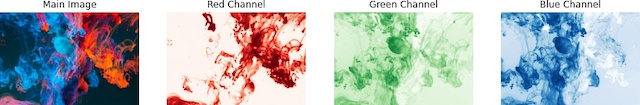

In LAB color space, there also three numbers for each pixel but with different meanings. The first number (channel), L, encodes the Lightness of each pixel. Just visualising this channel (the second image in the row below) will appear as a black and white image. The A and B channels encode how much green-red and yellow-blue each pixel is, respectively. In the following image you can see each channel of LAB color space separately.
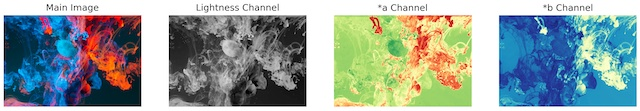

To train a model for colorization, we give it a grayscale image and hope that it will make it colorful. When using LAB, we give the L channel to the model and let the model predict the other two channels (A, B) and after its prediction, we concatenate all the channels to get the colorful image. 

If we use RGB, I have to first convert your image to grayscale, feed the grayscale image to the model and hope it will predict 3 number arrays. This is a way more difficult and unstable task due to the many more possible combinations of 3 numbers compared to two numbers. If we have 256 choices (in a 8-bit unsigned integer image) for each number, predicting the three numbers for each of the pixels is choosing between 256³ combinations which is more than 16 million choices. But when predicting two numbers using the LAB system, we have only about 65000 choices.

The script following takes reference from this [blog post](https://towardsdatascience.com/colorizing-black-white-images-with-u-net-and-conditional-gan-a-tutorial-81b2df111cd8) 

# Prepare dataset

I'm using 20,000 images from COCO dataset for training. The dataset should be quite general and should contain many different scenes and locations to which the model will learn to colorize. I loaded the COCO-2017 dataset from Kaggle data repository and sampled 20,000 images from the train folder. I also sampled 100 images from the validation folder. The validation images are to only show how the model is able to colourise across the training epochs.

In [ ]:
train_path = "/kaggle/input/coco-2017-dataset/coco2017/train2017"
val_path = "/kaggle/input/coco-2017-dataset/coco2017/val2017"

train_paths = glob.glob(train_path + "/*.jpg", recursive = True)
val_paths = glob.glob(val_path + "/*.jpg", recursive = True)
print("Total number of train images: {}".format(len(train_paths)))
print("Total number of validation images: {}".format(len(val_paths)))

np.random.seed(425)
train_paths = np.random.choice(train_paths, 20000, replace=False)
val_paths = np.random.choice(val_paths, 100, replace=False) 
print(len(train_paths), len(val_paths))

# Making Datasets and DataLoaders

Referring to the notebook [here](https://colab.research.google.com/github/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/Image%20Colorization%20with%20U-Net%20and%20GAN%20Tutorial.ipynb#scrollTo=GU6OKXgblJVw), create a dataset class to handle the data pre-processing work, such as resizing and horizontal flipping horizontally (flipping only if it is training set). Then read the images in RGB format and convert the images to LAB color space. Then, make a custom Dataloader from Pytorch Dataloader.

In [ ]:
class ColorizationDataset(Dataset):
    def __init__(self, paths, image_size, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((image_size, image_size),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(),
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((image_size, image_size),  Image.BICUBIC)
        
        self.split = split
        self.size = image_size
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)


def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs):
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [ ]:
train_dl = make_dataloaders(paths=train_paths, image_size = 256, split='train')
val_dl = make_dataloaders(paths=val_paths, image_size = 256, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

# Generator with UNet

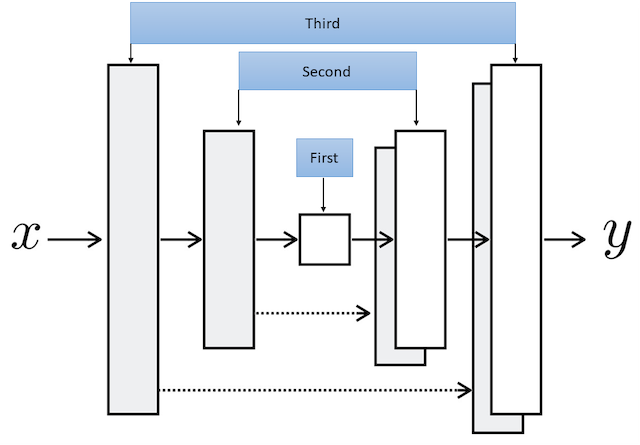

The Colourise model is essentially a GAN that is implemented by a UNet with ResNet backbone. The GAN generator with ResNet (the downsampling path) is trained in two stages. First, the generator with ResNet backbone is pre-trained in a supervised and deterministic manner. Then the whole generator is trained on the task of colourisation with L1 loss.

In [ ]:
# pip install fastai==2.4
from fastai.vision.learner import create_body
# from torchvision.models.resnet import resnet34
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

In [ ]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     body = create_body(resnet34, pretrained=True, n_in=n_input, cut=-2)
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

# Discriminator

The model architecture of the discriminator is done by stacking blocks of Conv-BatchNorm-LeakyReLU to decide whether the input image is fake or real. Notice that the first and last blocks do not use normalization and the last block has no activation function. It will use the custom defined loss function.

The term "Patch" Discriminator is used here. Originally, a discriminator outputs one scalar number which represents how much the model thinks the input is real or fake. In a patch discriminator, the model outputs one number for every patch of pixels (e.g., 70 by 70) of the input image and for each of them decides whether it is fake or not separately. Here, the model's output shape is 30 by 30 but it does not mean that the patches are 30 by 30. The actual patch size is obtained when we compute the receptive field of each of these 900 (30 * 30) output numbers which in our case will be 70 by 70.

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Define GAN Loss

This is a handy class we can use to calculate the GAN loss of our final model. In the init we decide which kind of loss we're going to use (which will be "vanilla" in our case) and register some constant tensors as the "real" and "fake" labels. Then when we call this module, it makes an appropriate tensor full of zeros or ones (according to what we need at the stage) and computes the loss.

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

# Model Initialization

Model weight values are initialised with a mean of 0.0 and standard deviation of 0.02 which are the proposed hyperparameters in the original article.

In [ ]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

# Define overall model class

This class brings together all the previous parts and implements a few methods to take care of training the complete model. 

In init, the generator and discriminator models are declared and initialized with the init_model function. Then, define the two loss functions and the optimizers of the generator and discriminator. The whole work is being done in optimize method of this class. First and only once per iteration (batch of training set) we call the module's forward method and store the outputs in fake_color variable of the class. Then, we train the discriminator by using backward_D method in which we feed the fake images produced by generator to the discriminator and label them as fake. Then we feed a batch of real images from training set to the discriminator and label them as real. We add up the two losses for fake and real and take the average and then call the backward on the final loss. Now, we can train the generator. In backward_G method we feed the discriminator the fake image and try to fool it by assigning real labels to them and calculating the adversarial loss. We use L1 loss and compute the distance between the predicted two channels and the target two channels and multiply this loss by a coefficient (lambda_L1 set with value of 100) to balance the two losses and then add this loss to the adversarial loss. Then we call the backward method of the loss.

In [ ]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

# Utiliy functions

A bunch of helper functions to log the losses of our network, visualize the results during training, convert format from LAB to RGB and etc.

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

# Define Training function

Custom train function for training the model

In [ ]:
def train_model(model, train_dl, epochs):
    val_data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
                                               # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects

        print(f"\nEpoch {e+1}/{epochs}")
        #print(f"Iteration {i}/{len(train_dl)}")
        log_results(loss_meter_dict) 
        visualize(model, val_data, save=False)

# Pre-Training the generator with UNet

With this simple function, we pretrain the generator with x epochs and then we save its weights. The trained backbone model will then be used as the generator for the GAN.

In [ ]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    print("Training model with {} epochs".format(epochs))
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_meter.update(loss.item(), L.size(0))
            
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()
pretrain_generator(net_G, train_dl, opt, criterion, 15)
torch.save(net_G, "res18_unet.pt")

# Overall model training (both Generator and Discriminator)

In [ ]:
net_G = torch.load("res18_unet.pt", map_location=device)
model = MainModel(net_G=net_G)
train_model(model, train_dl, 20)
torch.save(model, "final_model_resnet18.pt")